# Cloud model implementation
Felix Zaussinger, 01.04.2019

## 1) Definition of the backscattering coefficient

The scattering coefficient is defined as the differential scattering cross section $d\sigma$ per differential unit area $dA$:

$$\sigma_0 = \frac{d\sigma}{dA}$$

Equivalent names are __sigma nought__ or __normalised radar cross section__ and in the case of a monostatic radar, $\sigma_0$ is called the __backscattering coefficient__.

Assumptions:
1. Observed area consists of many individual point scatters with random locations and amplitudes
2. No single scatterer's amplitude dominates

## 2) Backscatter from Vegetation
We need to consider:
1. Volume scattering from vegetation canopies
2. Surface scattering from the underlying soil surface
3. Volume-surface scattering interaction term

The total backscatter can then be written as:

$$\sigma^{0}_{can} = \sigma^{0}_{v} + \sigma^{0}_{s} + \sigma^{0}_{sv}$$

One approach to model these interactions is the __Cloud Model__, which consists of three layers:
1. Air
    - Downwelling radiation is not attenuated until reaching the air-vegetation boundary.
2. Vegetation
    - Individual scatteres are uniformly distibuted throughout a homogenous volume such as air. 
    - The vegetation layer can be thought of as a cloud which droplets are held in place by vegetative matter. 
    - The incoming radiation is exponentially attenuated as a function of extinction coefficient $k_e$ and distance $z$.
3. Soil
    - The downwelling radiation which has penetrated the vegetation layer is partly reflected backwards as a function of the Fresnel coefficient $r_I$.
    - The $\sigma^{0}$ due to soil scattering is governed by the reflection properties of the soil and the loss in the vegetation layer.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
import ipywidgets as widgets

%matplotlib notebook
%matplotlib notebook

### Parameters

In [6]:
# incidence angle
thetas = np.linspace(20,75,100)
thetas_rad = np.deg2rad(thetas)

### Bare-soil model (Champion 1996)

Function of soil moisture and incidence angle. Multiplicative effect in the linear domain, additive effect in the decibel domain. In a linear model, the radar response from bare soil is related to volumetric soil water content of the first soil centimeters $m_v$, where D is the sensitivity of the radar signal to variations in $m_v$/SMC.

$$ \sigma^{0}_{s}(dB) = C_{\theta} + D m_v $$

$C_{\theta}$ is the value of $\sigma^{0}_{s}$ for a perfectly dry soil (i.e., $m_v=0 g cm^{-3}$) and calculated through a simple cosine model:

$$ C_{\theta} = C1 + C2 \cos(\theta)^{C3}$$

The dependence of backscatter on incidence angle is accounted for by the C-parameters:

- C1: $\sigma^{0}_{s}$ for $\theta=90°$
- C2: $\sigma^{0}_{s}$ over $\theta=[0°-60°]$
- C3: shape factor of the cosine model (connected to angular decrease)

In [7]:
def bare_soil_model(theta, mv):
    """Returns sigma0_soil in dB given the incidence angle theta and volumetric soil water content mv."""
    
    # Cosine model parameters for 5.3 GHz and HH pol from Champion (1996)
    C1, C2, C3 = (-29.2, 27.2, 2.8)
    
    # Soil moisture sensitivity D
    D = 0.28 # 0.32 also feasible

    C_theta = C1 + C2 * np.cos(theta) ** C3
    return C_theta + D * mv

<IPython.core.display.Javascript object>


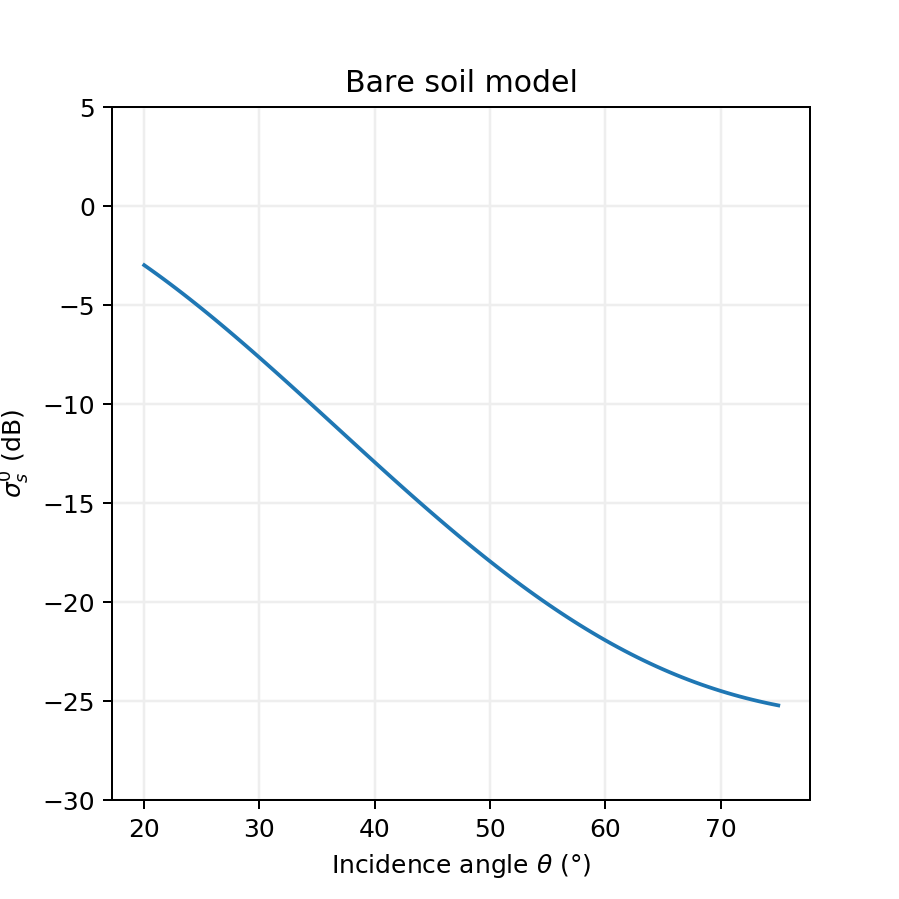

interactive(children=(FloatSlider(value=0.0, description='$SMC (g/cm^{3})$', max=40.0, step=1.0), Output()), _…

<function __main__.update(smc)>

In [8]:
# mv: from 0.02 (dry) to 0.3 (wet)
smc = 1

sigma0_bare_soil = bare_soil_model(thetas_rad, smc)

fig, ax = plt.subplots(figsize=(5,5))
ax.grid(color='#EEEEEE', linewidth=1, linestyle='solid')

line, = ax.plot(thetas, sigma0_bare_soil)

ax.set_title('Bare soil model')
ax.set_xlabel(r'Incidence angle $\theta$ (°)')
ax.set_ylabel(r'$\sigma^{0}_{s}$ (dB)')
ax.set_ylim(-30, 5)


def update(smc):
    sigma0_bare_soil = bare_soil_model(thetas_rad, smc)
    line.set_ydata(sigma0_bare_soil)

smc_slider = widgets.FloatSlider(min=0, max=40, step=1, value=0, description=r'$SMC (g/cm^{3})$')
widgets.interact(update, smc=smc_slider)

### Cloud model

Single scattering albedo: $\alpha = \frac{k_s}{k_e}$

Two-way attenuation factor: $\gamma = e^{-\frac{2\tau}{\cos(\theta)}}$

Parameters: $\theta$, $k_s$, $k_e$, $\tau$

Individual contributions:
- Volume component $\sigma^{0}_{v} = \frac{\alpha}{2} (1-\gamma^2)$ 
- Attenuated soil component: $\gamma^2 \sigma^{0}_{soil}$
- Soil-volume interaction component: often neglected (1) due to it's complex relationship, 2) due to limited contribution)

#### Abstract: Attema, E. P. W., and Fawwaz T. Ulaby. "Vegetation modeled as a water cloud." Radio science 13.2 (1978): 357-364.


Because the microwave dielectric constant of dry vegetative matter is much smaller (by an order of magnitude or more) than the dielectric constant of water, and because a vegetation canopy is usually composed of more than 99% air by volume, it is proposed that the canopy can be modeled as a water cloud whose droplets are held in place by the vegetative matter. Such a model was developed assuming that the canopy "cloud" contains identical water droplets randomly distributed within the canopy. By integrating the scattering and attenuation cross-section contributions of N droplets per unit volume over the signal pathlength through the canopy, an expression was derived for the backscattering coefficient as a function of three target parameters: volumetric moisture content of the soil, volumetric water content of the vegetation, and plant height. Regression analysis of the model predictions against scattering data acquired over a period of four months at several angles of incidence (0°-70°) and frequencies (8-18 GHz) for HH and VV polarizations yields correlation coefficients that range from .7 to .99 depending on frequency, polarization, and crop type. The corresponding standard errors of estimate range from 1.1 to 2.6 dB.

In [9]:
def dB2lin(x):
    return np.power(10, x/10)

def lin2dB(x):
    return 10* np.log10(x)

def cloud_model(theta, smc, alpha, tau):
    """"""
    # Two-way attenuation factor
    y2 = np.exp(-2*tau/np.cos(theta))
    
    # compute bare soil contribution and convert back to linear scale
    sigma0_soil_dB = bare_soil_model(theta, smc)
    sigma0_soil_linear = dB2lin(sigma0_soil_dB)
    
    # compute canopy backscattering coefficient using the cloud model and convert to dB scale
    sigma0_can = ((3*alpha*np.cos(theta))/4 * (1-y2)) + (y2 * sigma0_soil_linear)
    
    # return total, volume, soil and soil-volume components
    return {"Canopy": lin2dB(sigma0_can), # total canopy backscatter,
            "Volume": lin2dB(((3*alpha*np.cos(theta))/4 * (1-y2))), # volume term
            "Soil": lin2dB(y2 * sigma0_soil_linear)} # soil term

<IPython.core.display.Javascript object>


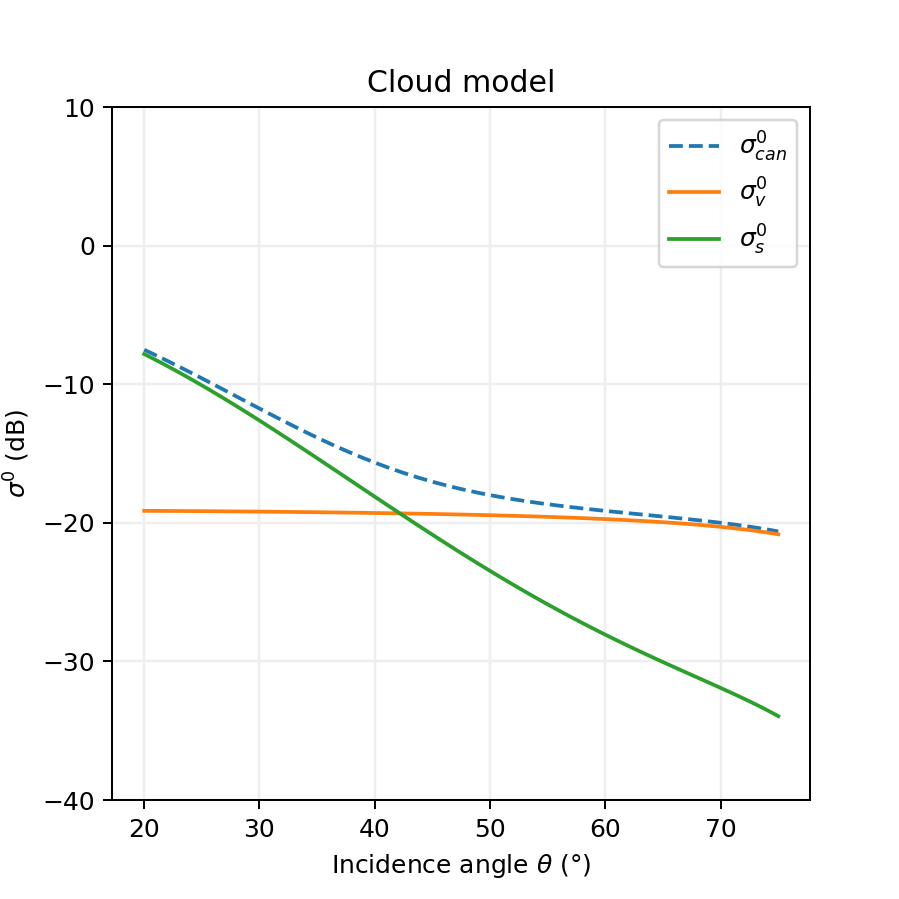

interactive(children=(FloatSlider(value=0.1, description='$\\tau$ (Np)', max=1.0, min=0.01, step=0.05), FloatS…

<function __main__.update(tau, alpha, smc)>

In [10]:
# params
tau = 0.1
alpha = 0.1
smc = 1

# calculate backscatter curves
cloud_model_terms = cloud_model(thetas_rad, smc, alpha, tau) # canopy backscatter

# create figure
fig, ax = plt.subplots(figsize=(5,5))
ax.grid(color='#EEEEEE', linewidth=1, linestyle='solid')

# plot lines
sigma0_canopy_plot, = ax.plot(thetas, cloud_model_terms['Canopy'], label=r'$\sigma^{0}_{can}$', linestyle='--')
sigma0_volume_plot, = ax.plot(thetas, cloud_model_terms['Volume'], label=r'$\sigma^{0}_{v}$')
sigma0_soil_plot, = ax.plot(thetas, cloud_model_terms['Soil'], label=r'$\sigma^{0}_{s}$')

# labelling
ax.set_title('Cloud model')
ax.set_xlabel(r'Incidence angle $\theta$ (°)')
ax.set_ylabel(r'$\sigma^{0}$ (dB)')
ax.set_ylim(-40, 10)
ax.legend()

# interactive plot
def update(tau, alpha, smc):
    # update model
    cloud_model_terms = cloud_model(thetas_rad, smc, alpha, tau) # canopy backscatter
    
    # update figure
    sigma0_canopy_plot.set_ydata(cloud_model_terms['Canopy'])
    sigma0_volume_plot.set_ydata(cloud_model_terms['Volume'])
    sigma0_soil_plot.set_ydata(cloud_model_terms['Soil'])

# sliders
tau_slider = widgets.FloatSlider(min=0.01, max=1, step=0.05, value=0.1, description=r'$\tau$ (Np)')
alpha_slider = widgets.FloatSlider(min=0.01, max=1, step=0.05, value=0.1, description=r'$\alpha$')
smc_slider = widgets.FloatSlider(min=0, max=40, step=1, value=0, description=r'$SMC (g(cm^{3})$')

widgets.interact(update, tau=tau_slider, alpha=alpha_slider, smc=smc_slider)